In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [3]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [4]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [5]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)

In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [7]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [8]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [9]:
## Step 2: Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN Layer
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through RNN
        out, _ = self.rnn(x, h0)

        # Take last time step output
        out = out[:, -1, :]

        # Pass through fully connected layer
        out = self.fc(out)

        return out

In [11]:
model = RNNModel(input_size=1, hidden_size=50, num_layers=2, num_classes=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
!pip install torchinfo

In [13]:
from torchinfo import summary

# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))


Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 50]              7,750
├─Linear: 1-2                            [64, 1]                   51
Total params: 7,801
Trainable params: 7,801
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 29.76
Input size (MB): 0.02
Forward/backward pass size (MB): 1.54
Params size (MB): 0.03
Estimated Total Size (MB): 1.58

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, labels in train_loader:

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.0418
Epoch [2/20], Loss: 0.0037
Epoch [3/20], Loss: 0.0008
Epoch [4/20], Loss: 0.0006
Epoch [5/20], Loss: 0.0007
Epoch [6/20], Loss: 0.0006
Epoch [7/20], Loss: 0.0005
Epoch [8/20], Loss: 0.0005
Epoch [9/20], Loss: 0.0005
Epoch [10/20], Loss: 0.0005
Epoch [11/20], Loss: 0.0004
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0004
Epoch [15/20], Loss: 0.0005
Epoch [16/20], Loss: 0.0004
Epoch [17/20], Loss: 0.0004
Epoch [18/20], Loss: 0.0004
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0004


Name:SAKTHIVEL S
Register Number:212223220090


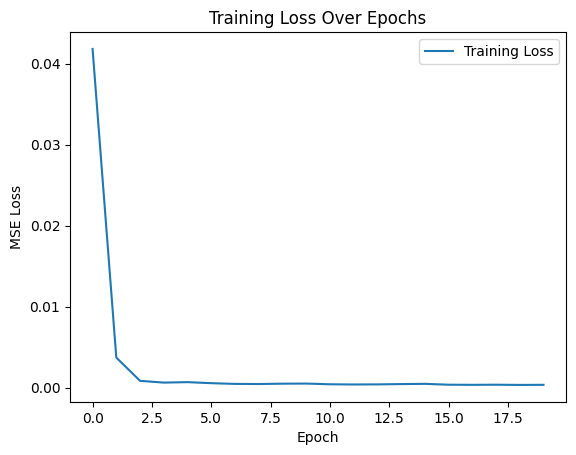

In [17]:
# Plot training loss
print('Name:SAKTHIVEL S')
print('Register Number:212223220090')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Name:SAKTHIVEL S
Register Number: 212223220090


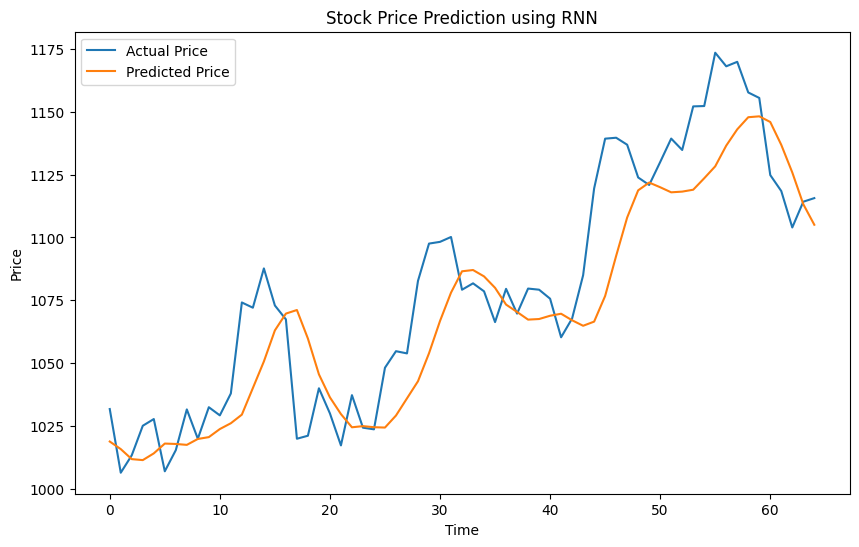

Predicted Price: [1105.0597]
Actual Price: [1115.65]


In [19]:
## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
print('Name:SAKTHIVEL S')
print('Register Number: 212223220090')
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')
